# Data Gathering
This project uses daily data on the stocks in the Dow Jones Industrial Average starting in January 2010.  A chart will be created for each stock every 5 trading days and the target is the stock's movement after 10 trading days.  This notebook details how to gather that data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
import time
import datetime
from scipy import stats

!pip install yfinance
import yfinance as yf

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr

!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
from mpl_finance import candlestick2_ohlc

     \ 306.0 kB 2.7 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-py3-none-any.whl size=8437 sha256=7c8f917a5c18cc04d47aa0a4b43364c96b6a818bfde9f91d5b8599d5424f72af
  Stored in directory: /tmp/pip-ephem-wheel-cache-a729fp45/wheels/f8/65/b0/57142851638a58e1cdc9eb1bd0f99c3e38b516db6b2c0cfe9b
Successfully built mpl-finance


### Example of Single Chart
This is to demonstrate what an individual stock chart looks like. Later this logic is put into a function to gather all of the necessary data.  The Scaled Result printed below is the stock's movement after 10 days scaled to the height of the chart.  The True Result is what would normally be called Return on Investment in the investment community.

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2010-01-04  15.615220  15.678981  15.547723  15.610239  15.610239   78541293
2010-01-05  15.620949  15.637387  15.480475  15.541497  15.541497  120638494
2010-01-06  15.588072  15.588072  15.102393  15.149715  15.149715  159744526
2010-01-07  15.178109  15.193053  14.760922  14.797037  14.797037  257533695
2010-01-08  14.744733  15.024933  14.672753  14.994298  14.994298  189680313
...               ...        ...        ...        ...        ...        ...
2019-12-20  68.167503  68.181999  67.449997  67.479500  67.479500   66300000
2019-12-23  67.793503  67.989998  67.325500  67.442001  67.442001   17662000
2019-12-24  67.425003  67.513000  67.139000  67.178001  67.178001    6950000
2019-12-26  67.308502  68.066353  67.223503  68.019997  68.019997   13350000
2019-12

<ipython-input-3-11c748e0d76d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['Date'],axis = 1,inplace = True)


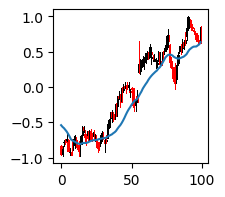

In [3]:
i = 500                 # This is the chart formed 500 trading days ago
days_in_chart   = 100     # The chart will be 100 days back with each bar representing 1 trading day
predict_forward =10    # We are predicting the stock movement 10 days into the future
ma_len = 20        # The chart will have a 20 moving average plotted onto it

yf.pdr_override()
y_symbols = ['GOOG']
from datetime import datetime
startdate = datetime(2010,1,1)
enddate   = datetime(2019,12,30)

stock_data = yf.download(y_symbols, start = startdate, end = enddate)

print(stock_data)

stock_data['Date'] = stock_data.index
stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
stock_data['Date'] = stock_data['Date'].dt.date

stock_data  = stock_data.reset_index(drop=True)
stock_dates = stock_data['Date'].values
stock_data['ma'] = stock_data.Close.rolling(ma_len).mean()
data = stock_data.iloc[len(stock_data)-i-days_in_chart:len(stock_data)-i]

# Below normalizes the charts so that the scales are all the same
low  = data.Low.min()
high = data.High.max()
mid  = (high+low)/2
data.drop(['Date'],axis = 1,inplace = True)
data.reset_index(inplace = True)
data = (data-mid)/((high-low)/2)

# Result is the stock movement relative to the scaled chart
result = (stock_data.Close[len(stock_data)-i+predict_forward]-stock_data.Close[len(stock_data)-i])/(high-low)

# True_result is what would also be called return on investment
true_result = (stock_data.Close[len(stock_data)-i+predict_forward]-stock_data.Close[len(stock_data)-i])/stock_data.Close[len(stock_data)-i]

# Determining if the stock went up or down
up_dn = 0
if result > 0:
    up_dn = 1

# Creating the plot
fig, ax = plt.subplots(figsize = (2,2))
candlestick2_ohlc(ax,data['Open'],data['High'],data['Low'],data['Close'],width = 1,alpha = 1)
plt.plot(data.ma)

print('Scaled Result: ',round(result,3))
print('True Result: ',round(true_result,3))

### Function to Create and Store all Charts
This function uses the above code and puts it into a loop to create and store the charts and other attributes for a single stock.  There is a quirk about the chart drawing function itself that makes it impossible to simply put this function in a loop for all stocks in question.  When the candlestick2_ohlc function runs, it must print the charts in order to remove them from the active memory; thus the computer slows down dramatically and can even run out of memory before it can print all of the thousands of charts and thus clear its active memory.  In order to get around this it is advisable to run one stock at a time per cell and merge the new data into the dataframes.   It is an extra headache but I demonstrate the workaround code in the following cells.  For the sake of runtime and brevity I gathered the data using this technique in a different notebook and pickled it into later notebooks.

In [4]:
import os
from datetime import date
def get_ticker_charts(stock,count):
    days_in_chart=100
    predict_forward=10
    ma_len=20
    VALIDTAION_CUTOFF_DATE = date(2016, 7, 1)   # All charts before this date will be in the training data set
    TEST_CUTOFF_DATE = date(2017, 7, 1)         # All charts after this date will be in the testing set
    # Initiate variables
    if not os.path.exists("all_charts"):
      os.makedirs("all_charts")
    x_train = np.array([])
    x_valid = None
    x_test = None
    y_train = []
    y_valid = []
    y_test = []
    invest_return_test=[]
    invest_return_valid=[]
    invest_return_train=[]
    true_return_test=[]
    true_return_valid=[]
    true_return_train=[]
    trade_dates=[]
    ticker=[]
    print(stock)
    stock_data = yf.download(stock)
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
    stock_data['Date'] = stock_data['Date'].dt.date
    stock_data = stock_data.reset_index(drop=True)
    stock_dates = stock_data['Date'].values
    stock_data['ma']=stock_data.Close.rolling(ma_len).mean()
    start=datetime.now()
    results=pd.DataFrame([])
    p=count*10000
    for i in range(days_in_chart+10,len(stock_data)-predict_forward-1,5):
        try:
            if i%500==0:
                print(i)
                print(datetime.now()-start)
            else:
                None
            # Select the 100 day range to create the chart
            data=stock_data.iloc[len(stock_data)-i-days_in_chart:len(stock_data)-i]
            low=data.Low.min()
            high=data.High.max()
            mid=(high+low)/2
            data = data.copy()
            data.drop(['Date'], axis=1, inplace=True)
            data.reset_index(inplace=True)
            data=(data-mid)/((high-low)/2)
            result=(stock_data.Close[len(stock_data)-i+predict_forward]-stock_data.Close[len(stock_data)-i])/(high-low)
            true_result=(stock_data.Close[len(stock_data)-i+predict_forward]-stock_data.Close[len(stock_data)-i])/stock_data.Close[len(stock_data)-i]
            up_dn=0
            if result>0:
                up_dn=1
            fig, ax = plt.subplots(figsize=(2,2))
            candlestick2_ohlc(ax,data['Open'],data['High'],data['Low'],data['Close'],width=1,alpha=1)
            plt.plot(data.ma)
            # The saving, opening and resaving process allows for the chart to be more easily cropped and
            # stored into an array. The uncompressed chart is also stored in a folder in case of need for
            # further use
            fig.savefig('plot1.png')
            img_obj=Image.open('plot1.png')
            fig2=img_obj.crop((23,18,130,125))
            location='all_charts/plot'+str(p+i)+'.png'
            fig2.save(location)
            img=cv2.imread(location,0)
            results=results.append(pd.DataFrame({'location':location,'finish':result,'i':p+i},index=[0]),ignore_index=True)
            # This puts the chart and its attributes into the propper variables
            if (stock_dates[i] >=TEST_CUTOFF_DATE):
                x_test = np.vstack([x_test, [img]]) if x_test is not None else np.array([img])
                y_test.append(up_dn)
                invest_return_test.append(result)
                true_return_test.append(true_result)
                trade_dates.append(stock_dates[i])
                ticker.append(stock)
            elif (stock_dates[i] >= VALIDTAION_CUTOFF_DATE) and (stock_dates[i] < TEST_CUTOFF_DATE):
                x_valid = np.vstack([x_valid, [img]]) if x_valid is not None else np.array([img])
                y_valid.append(up_dn)
                invest_return_valid.append(result)
                true_return_valid.append(true_result)
            else:
                x_train = np.vstack([x_train, [img]]) if x_train.size else np.array([img])
                y_train.append(up_dn)
                invest_return_train.append(result)
                true_return_train.append(true_result)

        except:
             print('error at: ',i)
    print(datetime.now()-start)
    print(x_train.shape)
    return x_train,x_valid,x_test,y_train,y_valid,y_test,invest_return_test,invest_return_valid,invest_return_train,trade_dates,ticker,results,true_return_test,true_return_valid,true_return_train

Below is the workaround to gather the data.  The ticker symbols for the Dow Jones stocks are listed and the next cell gathers the data for Apple.  It is important to run the cell for Apple only once because it initiates variables and running it again with another ticker would erase the previously gathered data.  For all stocks after the first one, use the bottom cell in this notebook and impliment each successive ticker symbol.  The bottom cell gathers the new stock's data, adds it to the main dataframes and then saves it via pickle.

In [5]:
STOCKS = ['AAPL','AXP', 'BA','CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'GS', 'HD', 'IBM',
          'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'UNH',
          'UTX', 'V', 'VZ', 'WMT', 'XOM']

In [6]:
stock = 'AAPL'
count=1
x_train,x_valid,x_test,y_train,y_valid,y_test,invest_return_test,invest_return_valid,invest_return_train,trade_dates,ticker,results,true_return_test,true_return_valid,true_return_train=get_ticker_charts(stock,count)
pickle_out=open("x_train.pickle","wb")
pickle.dump(x_train,pickle_out)
pickle_out.close()
pickle_out=open("x_valid.pickle","wb")
pickle.dump(x_valid,pickle_out)
pickle_out.close()
pickle_out=open("x_test.pickle","wb")
pickle.dump(x_test,pickle_out)
pickle_out.close()
pickle_out=open("y_train.pickle","wb")
pickle.dump(y_train,pickle_out)
pickle_out.close()
pickle_out=open("y_valid.pickle","wb")
pickle.dump(y_valid,pickle_out)
pickle_out.close()
pickle_out=open("y_test.pickle","wb")
pickle.dump(y_test,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_test.pickle","wb")
pickle.dump(invest_return_test,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_valia.pickle","wb")
pickle.dump(invest_return_valid,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_train.pickle","wb")
pickle.dump(invest_return_train,pickle_out)
pickle_out.close()
pickle_out=open("trade_dates.pickle","wb")
pickle.dump(trade_dates,pickle_out)
pickle_out.close()
pickle_out=open("ticker.pickle","wb")
pickle.dump(ticker,pickle_out)
pickle_out.close()
pickle_out=open("true_return_test.pickle","wb")
pickle.dump(true_return_test,pickle_out)
pickle_out.close()
pickle_out=open("true_return_valid.pickle","wb")
pickle.dump(true_return_valid,pickle_out)
pickle_out.close()
pickle_out=open("true_return_train.pickle","wb")
pickle.dump(true_return_train,pickle_out)
pickle_out.close()
print('(x_train ',x_train.shape)
print('y_train ',len(y_train))

Output hidden; open in https://colab.research.google.com to view.

In [7]:
stock='AXP'
count+=1
x_train2,x_valid2,x_test2,y_train2,y_valid2,y_test2,invest_return_test2,invest_return_valid2,invest_return_train2,trade_dates2,ticker2,results2,true_return_test2,true_return_valid2,true_return_train2=get_ticker_charts(stock,count)
x_train = np.vstack([x_train, x_train2])
x_valid = np.vstack([x_valid, x_valid2])
x_test = np.vstack([x_test, x_test2])
y_train.extend(y_train2)
y_valid.extend(y_valid2)
y_test.extend(y_test2)
invest_return_test.extend(invest_return_test2)
invest_return_valid.extend(invest_return_valid2)
invest_return_train.extend(invest_return_train2)
true_return_test.extend(true_return_test2)
true_return_valid.extend(true_return_valid2)
true_return_train.extend(true_return_train2)
trade_dates.extend(trade_dates2)
ticker.extend(ticker2)
pickle_out=open("x_train.pickle","wb")
pickle.dump(x_train,pickle_out)
pickle_out.close()
pickle_out=open("x_valid.pickle","wb")
pickle.dump(x_valid,pickle_out)
pickle_out.close()
pickle_out=open("x_test.pickle","wb")
pickle.dump(x_test,pickle_out)
pickle_out.close()
pickle_out=open("y_train.pickle","wb")
pickle.dump(y_train,pickle_out)
pickle_out.close()
pickle_out=open("y_valid.pickle","wb")
pickle.dump(y_valid,pickle_out)
pickle_out.close()
pickle_out=open("y_test.pickle","wb")
pickle.dump(y_test,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_test.pickle","wb")
pickle.dump(invest_return_test,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_valid.pickle","wb")
pickle.dump(invest_return_valid,pickle_out)
pickle_out.close()
pickle_out=open("invest_return_train.pickle","wb")
pickle.dump(invest_return_train,pickle_out)
pickle_out.close()
pickle_out=open("trade_dates.pickle","wb")
pickle.dump(trade_dates,pickle_out)
pickle_out.close()
pickle_out=open("ticker.pickle","wb")
pickle.dump(ticker,pickle_out)
pickle_out.close()
results=results.append(results2,ignore_index=True)
pickle_out=open("true_return_test.pickle","wb")
pickle.dump(true_return_test,pickle_out)
pickle_out.close()
pickle_out=open("true_return_valid.pickle","wb")
pickle.dump(true_return_valid,pickle_out)
pickle_out.close()
pickle_out=open("true_return_train.pickle","wb")
pickle.dump(true_return_train,pickle_out)
print('results df: ',results.shape)
print('(x_train ',x_train.shape)
print('(x_train2 ',x_train2.shape)
print('y_train ',len(y_train))
print('y_train2 ',len(y_train2))
print('y_test ',len(y_test))
print('true_return ',len(true_return_test))

Output hidden; open in https://colab.research.google.com to view.

### For the next section, please see the notebook titled "CNN_Multi_Classification"

In [8]:
print("Process completed")

Process completed
